In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pandas as pd
import segmentation_models_pytorch as smp
import shutil

from PIL import Image

# Exploratory Data Analysis

## Data cleaning

In [ ]:
# Retrieve all images that have a tumour (benign or not)
data_dir = r'Dataset_BUSI_with_GT/not_normal'

files = glob.glob(data_dir + '/*/*.png')

scan_paths = [f for f in files if ('mask' not in f)]
mask_paths = [f for f in files if ('mask' in f)]

print(f'There are {len(scan_paths)} scans and {len(mask_paths)} masks.')

There are 0 scans and 0 masks.


When there is more than one tumor in an image, there are different masks for that same image. Thus we will sum these masks to get a single mask by image.

In [ ]:
img_names = [os.path.basename(path).split('_')[0] for path in mask_paths]

# Create dictionary -> img_name (str): mask is unique or not (bool)
is_unique_dict = {name: True for name in img_names}
for i, name in enumerate(img_names):
    for name2 in img_names[i+1:]:
        if (name == name2):
            is_unique_dict[name] = False
            break

for (img_name, is_unique) in is_unique_dict.items():
    # Get all masks corresponding to the image
    paths = glob.glob(data_dir + f'/*/{img_name}_mask*.png')
    masks = []
    for path in paths:
        mask = np.array(Image.open(path))
        # Handle RGB images
        if mask.ndim != 2:
            mask = mask[:, :, 0] / 255
        masks.append(mask)
    # Sum all masks into one
    masks = np.array(masks)
    final_mask = masks.sum(axis=0)
    # Save to a new folder
    plt.imsave(rf'Dataset_BUSI_with_GT/cleaned_data/{img_name}_mask.png', final_mask, cmap=cm.gray)

# Copy scans to the cleaned_data folder
for path in scan_paths:
    shutil.copyfile(path, r'Dataset_BUSI_with_GT/cleaned_data/' + os.path.basename(path))

# Creation of the Database

In [ ]:
data_dir = r'Dataset_BUSI_with_GT/cleaned_data'

files = glob.glob(data_dir + '/*.png')

scan_paths = [f for f in files if ('mask' not in f)]
mask_paths = [f for f in files if ('mask' in f)]

print(f'There are {len(scan_paths)} scans and {len(mask_paths)} masks.')

There are 647 scans and 647 masks.


In [ ]:
# Creation of the DataFrame with the paths to the images and their masks
database = pd.DataFrame({'image': scan_paths, 'mask': [path.split('.')[0] + '_mask.png' for path in scan_paths]})

for idx, mask_path in enumerate(database['mask']):
    mask = np.array(Image.open(mask_path))
    # For image with 4 channels
    if mask.ndim != 2:
        mask = mask[:,:,0] / 255
    database.loc[idx, 'n_tumor'] = mask.mean()
    database.loc[idx, 'malignant'] = ('malignant' in database.loc[idx, 'image']) 

#database.to_csv(r'Dataset_BUSI_with_GT/cleaned_data/data.csv', index=False)

database.head()

,image,mask,n_tumor,malignant
0,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,0.141447,False
1,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,0.044980,False
2,Dataset_BUSI_with_GT/cleaned_data/benign (18).png,Dataset_BUSI_with_GT/cleaned_data/benign (18)_...,0.198419,False
3,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,0.011075,False
4,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,0.014921,False


## Study of tumor size for unbalanced segmentation

In order to work in the unbalanced classification framework of the paper, we want to keep only images where the tumor is small without compromising too much the size of our dataset.

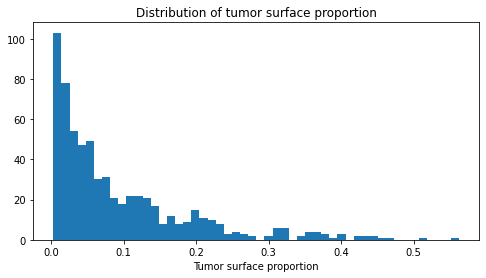

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(database['n_tumor'], bins=50)
plt.xlabel('Tumor surface proportion')
plt.title('Distribution of tumor surface proportion')
plt.savefig('tumor_surface.png')
plt.show()

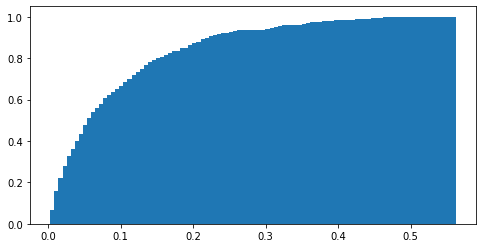

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(database['n_tumor'], density=True, cumulative=True, bins=100)
plt.show()

In [ ]:
thresh = 0.10
n_keep = len(database.loc[database['n_tumor'] < thresh])
n_tot = len(database)
print('By keeping image with less than {:.1f}% tumor, we keep {:.2f}% of the database, which corresponds to {} images.'.format(
            100*thresh, n_keep / n_tot, n_keep))

By keeping image with less than 10.0% tumor, we keep 0.66% of the database, which corresponds to 425 images.


# Training 

In [ ]:
import cv2

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Resize
from tqdm import tqdm

In [ ]:
# Define hyperparameters
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 30

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [ ]:
#
class MyDataset(data.Dataset):
    def __init__(self, df):
        self.database = df
    
    def __len__(self):
        return len(self.database)
    
    def __getitem__(self, idx):
        row = self.database.iloc[idx]
        # Open image and mask as grayscale
        img = np.array(Image.open(row['image']).convert('L')) / 255
        mask = np.array(Image.open(row['mask']).convert('L')) / 255

        # Resize images
        img = cv2.resize(np.float32(img), (256,256))
        mask = cv2.resize(np.float32(mask), (256,256))

        img = torch.tensor(img)
        img = img.unsqueeze(dim=0)

        # Make sure masks are binary
        mask = torch.tensor((mask > 0.5)).float()
  
        return img, mask

In [ ]:
#database = pd.read_csv('Dataset_BUSI_with_GT/cleaned_data/data.csv')
dataset_df = database.loc[database['n_tumor'] < 0.05]

database.head()

,image,mask,n_tumor
0,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,Dataset_BUSI_with_GT/cleaned_data/benign (158)...,0.141447
1,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,Dataset_BUSI_with_GT/cleaned_data/benign (121)...,0.044980
2,Dataset_BUSI_with_GT/cleaned_data/benign (18).png,Dataset_BUSI_with_GT/cleaned_data/benign (18)_...,0.198419
3,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,Dataset_BUSI_with_GT/cleaned_data/benign (166)...,0.011075
4,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,Dataset_BUSI_with_GT/cleaned_data/benign (128)...,0.014921


In [ ]:
# Split data into 80/20 training and validation sets
train_idx = np.random.choice(dataset_df.index, size=int(0.8*len(dataset_df)), replace=False)
val_idx = list(set(dataset_df.index) - set(train_idx))

train_ds = MyDataset(dataset_df.loc[train_idx])
val_ds = MyDataset(dataset_df.loc[val_idx])

train_loader = data.DataLoader(train_ds, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_ds, batch_size = BATCH_SIZE)

In [ ]:
# Compute statistics on training set
train_mean = 0
train_std = 0
for img, mask in train_loader:
  train_mean += img.mean()
  train_std += img.std()

train_mean /= len(train_loader)
train_std /= len(train_loader)
print('Mean:', train_mean, ('Std:', train_std))

Mean: tensor(0.3353) ('Std:', tensor(0.2172))


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
)

model = nn.Sequential(model, nn.Sigmoid())

model.to(device)


optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = torch.nn.BCELoss(reduction='mean')


def train(epoch):
    train_loss = 0
    acc = 0
    model.train()
    for (img, mask) in tqdm(train_loader, total=len(train_loader)):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img).squeeze(dim=1)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        pred = (output > 0.5)
        acc += (pred == (mask > 0.5)).float().mean()
        train_loss += loss.data.item()
    
    train_loss /= len(train_loader)
    acc /= len(train_loader)
    print(' Train Epoch: {} \tLoss: {:.6f}'.format(epoch, train_loss))
    return train_loss, acc

def validation():
    model.eval()
    validation_loss = 0
    acc = 0
    with torch.no_grad():
      for img, mask in val_loader:
          img, mask = img.to(device), mask.to(device)
          output = model(img).squeeze(dim=1)

          # sum up batch loss
          validation_loss += criterion(output, mask).data.item()

          pred = (output > 0.5)
          acc += (pred == (mask > 0.5)).float().mean()

    acc /= len(val_loader)
    validation_loss /= len(val_loader)
  
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.3f}'.format(
        validation_loss, acc))
    
    return validation_loss, acc

In [ ]:
save_dir = 'CE_loss'

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, EPOCHS + 1):
    best_val_acc = 0
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validation()
    model_file = save_dir + 'best_model.pth'
    
    # Fill lists for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(), model_file)

100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


 Train Epoch: 1 	Loss: 0.145173

Validation set: Average loss: 0.2459, Accuracy: 0.978


100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


 Train Epoch: 2 	Loss: 0.056863

Validation set: Average loss: 0.7874, Accuracy: 0.808


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


 Train Epoch: 3 	Loss: 0.033570

Validation set: Average loss: 0.2223, Accuracy: 0.929


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


 Train Epoch: 4 	Loss: 0.024110

Validation set: Average loss: 0.0448, Accuracy: 0.983


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


 Train Epoch: 5 	Loss: 0.019182

Validation set: Average loss: 0.0298, Accuracy: 0.989


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


 Train Epoch: 6 	Loss: 0.015275

Validation set: Average loss: 0.0288, Accuracy: 0.990


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


 Train Epoch: 7 	Loss: 0.014774

Validation set: Average loss: 0.0289, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


 Train Epoch: 8 	Loss: 0.013247

Validation set: Average loss: 0.0359, Accuracy: 0.989


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


 Train Epoch: 9 	Loss: 0.011464

Validation set: Average loss: 0.0327, Accuracy: 0.990


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


 Train Epoch: 10 	Loss: 0.010540

Validation set: Average loss: 0.0393, Accuracy: 0.989


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


 Train Epoch: 11 	Loss: 0.010905

Validation set: Average loss: 0.0370, Accuracy: 0.988


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


 Train Epoch: 12 	Loss: 0.011679

Validation set: Average loss: 0.0335, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


 Train Epoch: 13 	Loss: 0.013408

Validation set: Average loss: 0.0397, Accuracy: 0.990


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


 Train Epoch: 14 	Loss: 0.013257

Validation set: Average loss: 0.0354, Accuracy: 0.989


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


 Train Epoch: 15 	Loss: 0.009770

Validation set: Average loss: 0.0327, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


 Train Epoch: 16 	Loss: 0.008256

Validation set: Average loss: 0.0360, Accuracy: 0.990


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


 Train Epoch: 17 	Loss: 0.007713

Validation set: Average loss: 0.0369, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


 Train Epoch: 18 	Loss: 0.007117

Validation set: Average loss: 0.0390, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


 Train Epoch: 19 	Loss: 0.006503

Validation set: Average loss: 0.0380, Accuracy: 0.991


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


 Train Epoch: 20 	Loss: 0.006437

Validation set: Average loss: 0.0436, Accuracy: 0.990


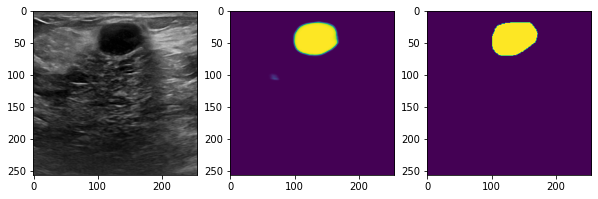

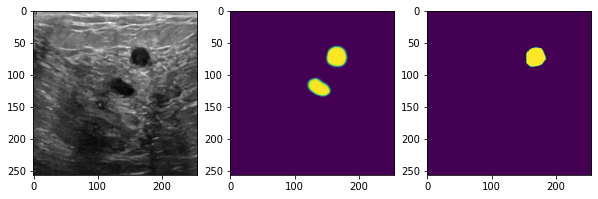

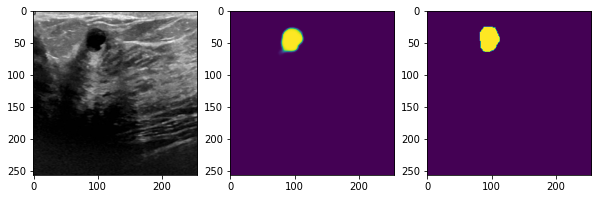

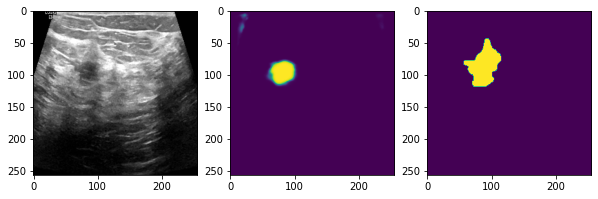

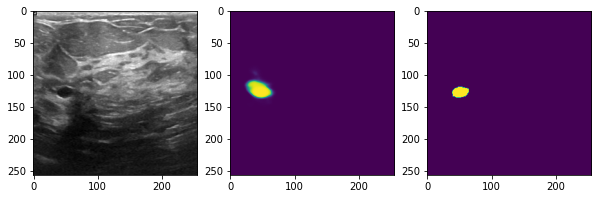

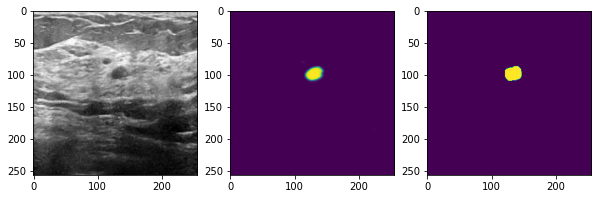

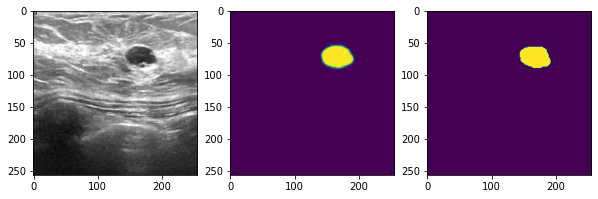

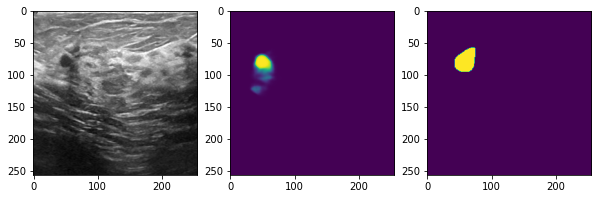

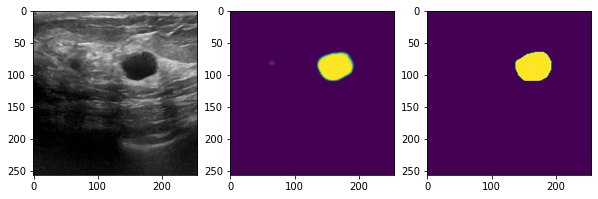

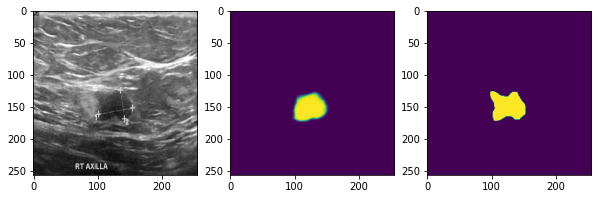

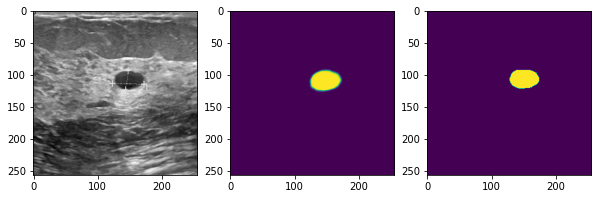

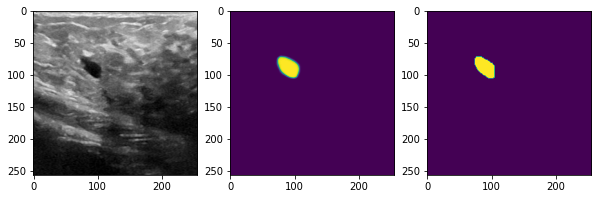

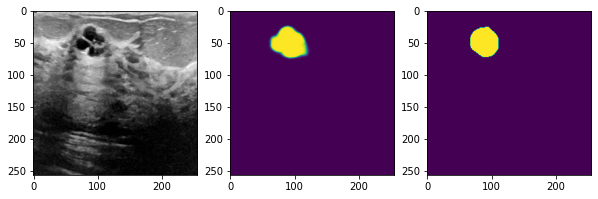

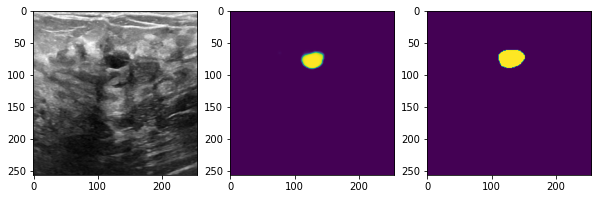

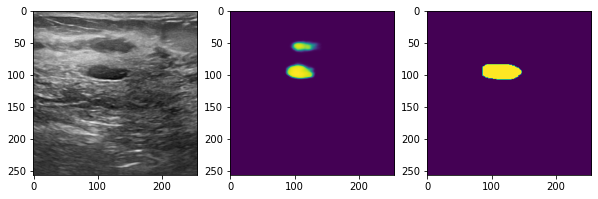

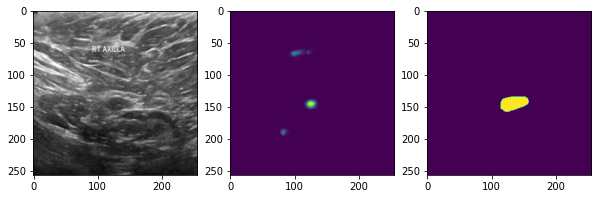

In [ ]:
for img, mask in val_loader:
  img = img.to(device)
  pred = model(img).squeeze(dim=1)
  for k in range(BATCH_SIZE):
    fig, axes = plt.subplots(1, 3, figsize=(10,5))
    axes[0].imshow(img[k].cpu().numpy()[0], cmap='gray')
    axes[1].imshow(pred[k].cpu().detach())
    axes[2].imshow(mask[k]>0.5)
    plt.show()
  
  break


# Using Boundary Loss


In [ ]:
import cv2

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchmetrics import F1Score
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Resize
from tqdm import tqdm

import torch.nn.functional as F
from losses import BoundaryLoss
from dataloader import dist_map_transform

In [ ]:
# Define a custom dataset to compute the distance map in the dataloader
class SliceSet(data.Dataset):
    def __init__(self, df):
        self.database = df
        self.disttransform = dist_map_transform([1, 1], 2)

    def __len__(self):
        return len(self.database)

    def __getitem__(self, idx):
        row = self.database.iloc[idx]
        img = np.array(Image.open(row['image']).convert('L')) / 255
        mask = np.array(Image.open(row['mask']).convert('L')) / 255

        img = cv2.resize(np.float32(img), (256,256))
        mask = cv2.resize(np.float32(mask), (256,256))

        img_tensor = torch.tensor(img)
        img_tensor = img_tensor.unsqueeze(dim=0)
        #img = torch.moveaxis(img, 2, 0)

        #img = (img - 0.344) / 0.218

        mask_tensor = torch.tensor((mask > 0.5)).long()

        one_hot_tensor = F.one_hot(mask_tensor) # Usualy transform from png to one_hot encoding
        dist_map_tensor = self.disttransform(mask)
        
        one_hot_tensor = torch.moveaxis(one_hot_tensor, -1, 0).float()

        return {"images": img_tensor,
                "gt": one_hot_tensor,
                "dist_map": dist_map_tensor}

In [ ]:
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [ ]:
#database = pd.read_csv('Dataset_BUSI_with_GT/cleaned_data/data.csv')
dataset_df = database.loc[database['n_tumor'] < 0.1]

print('There are {} images, with {}% malignant'.format(len(dataset_df), dataset_df['malignant'].mean()))

There are 425 images, with 0.20941176470588235% malignant


In [ ]:
train_idx = np.random.choice(dataset_df.index, size=int(0.8*len(dataset_df)), replace=False)
val_idx = list(set(dataset_df.index) - set(train_idx))

train_ds = SliceSet(dataset_df.loc[train_idx])
val_ds = SliceSet(dataset_df.loc[val_idx])

train_loader = data.DataLoader(train_ds, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_ds, batch_size = BATCH_SIZE)

In [ ]:
pos_weight = 100

model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=2,                      
)
model = nn.Sequential(model, nn.Softmax())
model.to(device)


#optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LR)

ce_loss = torch.nn.BCELoss(reduction='none')
bound_loss = BoundaryLoss(idc=[1])

f1_score = F1Score(task='binary').to(device)

def train(epoch):
    model.train()
    # Metrics
    train_loss = 0
    acc = 0
    f1 = 0

    # Parameter for weighting the boundary loss
    alpha = max(0, epoch/EPOCHS - 0.05)
    print('alpha:', alpha)

    for data_dict in tqdm(train_loader, total=len(train_loader)):
        img = data_dict['images'].to(device)
        mask = data_dict['gt'].to(device)
        dist_map_label = data_dict['dist_map'].to(device)

        optimizer.zero_grad()
        output = model(img).squeeze(dim=1)

        weight = torch.ones_like(output)
        weight[mask == 1] = pos_weight

        #loss = (ce_loss(output, mask) * weight).mean() + alpha * bound_loss(output, dist_map_label)
        loss = (1 - alpha) * (ce_loss(output, mask) * weight).mean() + alpha * bound_loss(output, dist_map_label)
        loss.backward()
        optimizer.step()

        #print('bl', bound_loss(output, dist_map_label))
        #print('ce', ce_loss(output, mask))

        pred = torch.argmax(output, dim=1)
        gt = torch.argmax(mask, dim=1)
        f1 += f1_score(pred, gt)
        acc += (pred == gt).float().mean()
        train_loss += loss.data.item() 
    
    train_loss /= len(train_loader)
    acc /= len(train_loader)
    f1 /= len(train_loader)

    f1 = acc.cpu().detach()
    acc = acc.cpu().detach()

    print(' Train Epoch: {} \tLoss: {:.6f}'.format(epoch, train_loss))
    return train_loss, f1

def validation():
    model.eval()
    validation_loss = 0
    acc = 0
    f1 = 0

    # Parameter for weighting the boundary loss
    alpha = max(0, epoch/EPOCHS - 0.05)

    with torch.no_grad():
      for data_dict in val_loader:
          img = data_dict['images'].to(device)
          mask = data_dict['gt'].to(device)
          dist_map_label = data_dict['dist_map'].to(device)

          output = model(img)

          weight = torch.ones_like(output)
          weight[mask == 1] = pos_weight

          # sum up batch loss
          #validation_loss += (ce_loss(output, mask) * weight).mean() + alpha * bound_loss(output, dist_map_label)
          validation_loss += (1 - alpha) * (ce_loss(output, mask) * weight).mean() + alpha * bound_loss(output, dist_map_label)

          pred = torch.argmax(output, dim=1)
          gt = torch.argmax(mask, dim=1)
          f1 += f1_score(pred, gt)
          acc += (pred == gt).float().mean()

    
    validation_loss /= len(val_loader)
    f1 /= len(val_loader)
    acc /= len(val_loader)

    validation_loss = validation_loss.cpu().detach()
    f1 = f1.cpu().detach()
    acc = acc.cpu().detach()
  
    print('\nValidation set: Average loss: {:.4f}, F1-score: {:.3f}'.format(
        validation_loss, f1))
    
    return validation_loss, f1

Initialized SurfaceLoss with {'idc': [1]}


In [ ]:
save_dir = 'rebalance_adam'
os.makedirs(save_dir, exist_ok=True)

train_losses = []
train_f1s = []
val_losses = []
val_f1s = []

best_val_f1 = 0
for epoch in range(1, EPOCHS + 1):
    train_loss, train_f1 = train(epoch)
    val_loss, val_f1 = validation()
    model_file = save_dir + '/best_model.pth'
    
    # Fill lists for plotting
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), model_file)
        print('Saving model')

alpha: 0


  0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 22/22 [00:28<00:00,  1.28s/it]


 Train Epoch: 1 	Loss: 14.039373

Validation set: Average loss: 5.9766, F1-score: 0.434
Saving model
alpha: 0.05


100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


 Train Epoch: 2 	Loss: 4.499638

Validation set: Average loss: 9.1933, F1-score: 0.467
Saving model
alpha: 0.09999999999999999


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


 Train Epoch: 3 	Loss: 3.171820

Validation set: Average loss: 3.5187, F1-score: 0.670
Saving model
alpha: 0.15000000000000002


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


 Train Epoch: 4 	Loss: 2.363643

Validation set: Average loss: 3.4732, F1-score: 0.603
alpha: 0.2


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


 Train Epoch: 5 	Loss: 1.871441

Validation set: Average loss: 3.0731, F1-score: 0.692
Saving model
alpha: 0.25


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


 Train Epoch: 6 	Loss: 1.607009

Validation set: Average loss: 3.4777, F1-score: 0.582
alpha: 0.3


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 7 	Loss: 1.359271

Validation set: Average loss: 2.4605, F1-score: 0.687
alpha: 0.35000000000000003


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 8 	Loss: 1.095762

Validation set: Average loss: 2.2701, F1-score: 0.716
Saving model
alpha: 0.4


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


 Train Epoch: 9 	Loss: 0.884367

Validation set: Average loss: 1.8742, F1-score: 0.711
alpha: 0.45


100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


 Train Epoch: 10 	Loss: 0.644611

Validation set: Average loss: 1.7210, F1-score: 0.715
alpha: 0.5


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 11 	Loss: 0.493171

Validation set: Average loss: 1.5524, F1-score: 0.731
Saving model
alpha: 0.5499999999999999


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


 Train Epoch: 12 	Loss: 0.385817

Validation set: Average loss: 1.5630, F1-score: 0.722
alpha: 0.6


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 13 	Loss: 0.293042

Validation set: Average loss: 1.4281, F1-score: 0.712
alpha: 0.6499999999999999


100%|██████████| 22/22 [00:19<00:00,  1.16it/s]


 Train Epoch: 14 	Loss: 0.192159

Validation set: Average loss: 1.2953, F1-score: 0.735
Saving model
alpha: 0.7


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


 Train Epoch: 15 	Loss: 0.148473

Validation set: Average loss: 1.0924, F1-score: 0.722
alpha: 0.75


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


 Train Epoch: 16 	Loss: 0.106434

Validation set: Average loss: 0.8651, F1-score: 0.720
alpha: 0.7999999999999999


100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


 Train Epoch: 17 	Loss: 0.012376

Validation set: Average loss: 0.6622, F1-score: 0.758
Saving model
alpha: 0.85


100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


 Train Epoch: 18 	Loss: -0.076449

Validation set: Average loss: 0.4701, F1-score: 0.757
alpha: 0.8999999999999999


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 19 	Loss: -0.137044

Validation set: Average loss: 0.2971, F1-score: 0.755
alpha: 0.95


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


 Train Epoch: 20 	Loss: -0.195403

Validation set: Average loss: 0.1081, F1-score: 0.742


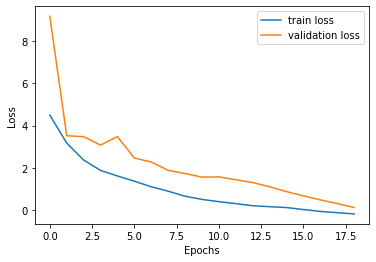

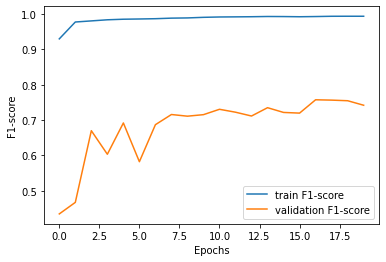

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses[1:], label='train loss')
plt.plot(val_losses[1:], label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig(save_dir + '/loss.png')
plt.show()


plt.plot(train_f1s[0:], label='train F1-score')
plt.plot(val_f1s[0:], label='validation F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epochs')
plt.legend()
plt.savefig(save_dir + '/f1_score.png')
plt.show()



In [ ]:
model_path = 'rebalance_adam' + '/best_model.pth'
model.load_state_dict(torch.load(model_path))

validation()

for data_dict in val_loader:
  model.eval()
  img = data_dict['images'].to(device)

  mask = data_dict['gt']
  mask_plot = torch.argmax(mask, dim=1)
  dist_map_label = data_dict['dist_map']

  pred = torch.argmax(model(img), dim=1)
  pred = model(img)[:, 1, :, :]

  for k in range(len(img)):
    if mask_plot[k].float().mean() < 0.05:
      fig, axes = plt.subplots(1, 3, figsize=(10,5))
      axes[0].imshow(img[k].cpu().numpy()[0], cmap='gray')
      axes[1].imshow(pred[k].cpu().detach())
      #plt.colorbar(axes[1].imshow(pred[k].cpu().detach()))
      axes[2].imshow(mask_plot[k]>0.5)
      plt.show()
  

Output hidden; open in https://colab.research.google.com to view.

# Visualization

In [ ]:
model_ce = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=2,                      
)
model_ce = nn.Sequential(model_ce, nn.Softmax())
model_ce.to(device)

model_bl = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=2,                      
)
model_bl = nn.Sequential(model_bl, nn.Softmax())
model_bl.to(device)


model_bl.load_state_dict(torch.load('rebalance_adam' + '/best_model.pth'))
model_ce.load_state_dict(torch.load('ce_adam' + '/best_model.pth'))

model_bl.eval()
model_ce.eval()

Sequential(
  (0): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNor

In [ ]:
from skimage.morphology import binary_dilation

kernel = np.ones((3,3),dtype=int) # for 4-connected

In [ ]:
for data_dict in val_loader:
  img = data_dict['images'].to(device)

  mask = data_dict['gt']
  mask_plot = torch.argmax(mask, dim=1)
  dist_map_label = data_dict['dist_map']

  pred_ce = torch.argmax(model_ce(img), dim=1)
  pred_bl = torch.argmax(model_bl(img), dim=1)
  #pred = model(img)[:, 1, :, :]

  for k in range(len(img)):
    if mask_plot[k].float().mean() < 0.05:
      fig, axes = plt.subplots(1, 3, figsize=(15,10))
      for i in range(3):
        axes[i].imshow(img[k].cpu().numpy()[0], cmap='gray')
        axes[i].axis('off')


      pred_ce_np = pred_ce[k].cpu().detach().numpy()
      boundaries = binary_dilation(pred_ce_np==0) & pred_ce_np
      boundaries = binary_dilation(boundaries)
      #boundaries = cv2.dilate(boundaries.astype('uint8'), kernel=np.ones((3,3)).astype('uint8'), iterations=1)
      axes[1].imshow(boundaries, cmap='bwr', alpha=1.*(boundaries > 0))

      pred_bl_np = pred_bl[k].cpu().detach().numpy()
      boundaries = binary_dilation(pred_bl_np==0) & pred_bl_np
      boundaries = binary_dilation(boundaries)
      #boundaries = cv2.dilate(boundaries.astype('uint8'), kernel=np.ones((3,3)).astype('uint8'), iterations=1)
      axes[2].imshow(boundaries, cmap='bwr', alpha=1.*(boundaries > 0))
      

      boundaries = binary_dilation(mask_plot[k]==0) & mask_plot[k].cpu().detach().numpy()
      boundaries = binary_dilation(boundaries)
      axes[0].imshow(boundaries>0, cmap='bwr', alpha=1.*(boundaries > 0))


      plt.show()
  

Output hidden; open in https://colab.research.google.com to view.